# GLLVM for longitudinal data: a pytorch implementation

We consider the following model

TODO:
* learn the nuisance parameters! To learn phi, make the encoder learn the zhats **before** AR(1) is applied, and take the gradient of the decoder. that is, make the decoder have phi as a parameter, and same for var_mu!
* allow for gaussian and binary data
* Compute the gradient that define the model
* allow for missing values and impute them


 ## Model Specification

Let  $y_{i1t},y_{i2t},\ldots,y_{ipt}$  be a set of $p$ response or observed variables at time $t,\ t=1,\ldots,T$ for  individual $i,\ i=1,\ldots,n$. Let $\mathbf{x}_{it}$ be a set of observed $k$-dimensional covariates at time $t,\ t=1,\ldots,T$.

Models for multivariate longitudinal data have to account for the three sources of variability
present in the data, that is (i) cross-sectional associations between the responses at a particular time point, (ii) cross-lagged
associations between different responses at different occasions, and  (iii) the association between repeated measures of the same response
over time. The first source of variability is accounted for
a time-dependent latent variable $z_{i1}, z_{i2},\ldots,z_{iT}$. Modeling the temporal evolution of the latent variable accounts for the cross-lagged associations between different responses over time.
The third source of variability can be accounted for a set of item-specific random effects $\mathbf{u}_{i}=(u_{i1}, \ldots, u_{ip})'$.

According to the GLLVM framework we have

\begin{align*}
   \nonumber y_{ijt}|\mu_{ijt} &\sim \mathcal{F}_j(y_{ijt}\vert \mu_{ijt}, \tau_j)\\
   \mu_{ijt}&=  g_j(\eta_{ijt})=g_j(\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij}\sigma_{u_j})\\ %  \label{eqn:GLLVM-model2}
\end{align*}
where $g_j(\cdot),j=1,\ldots,p$ is a known {\it link function}, $\eta_{ijt}=\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij},i=1,\ldots,n,j=1,\ldots,p, t=1,\ldots,T$ is the {\it linear predictor},  and $\mathcal{F}_j(y_{ijt}\vert \eta_{ijt}, \tau_j)$ denotes a distribution from the exponential family with mean $\mu_{ijt}$ and response variable-specific dispersion parameter $\tau_j$. \vspace{5pt}\\
The dynamics of the latent variable over time is modelled through a non-stationary autoregressive model of first order

\begin{equation*}
z_{it}=\phi z_{i,t-1} + \delta_{it}
\end{equation*}%
where  $z_{i1}\sim N(0,\sigma^2_{1})$ and $\delta_{it}\sim N(0,1)$.  Moreover, we assume the random effects independent of the latent variable and their common distribution $\mathbf{u}_{i}\sim N_p(\mathbf{0}, \boldsymbol I)$.


### Changes I propose:

allow x to depend on time.


## Measurement invariance

The  latent variable $z_{it}$ has to be the same (same meaning) across occasions.
Thus the measurement invariance assumption has to be tested on the data, that is 
all the measurement parameters  are invariant across occasions, that is $$\beta_{0jt}=\beta_{0j} \ \textrm{and } \ \lambda_{jt}=
\lambda_{j},$$ for all $t$, $t=1, \ldots, T$ and for all $j$, $j=1,\ldots, p$.
Under this assumption, the model is more parsimonious  and avoids some possible identification problem that might arise with
increasing the number of time points.

To ensure identification of the model, one necessary condition is that the latent variable has a scale and an origin. %When measurement
%invariance of loadings and intercepts is imposed,
Scale for  $z_{it}$  can be provided either by fixing one loading at a nonzero value or by
fixing the factor variance at a nonzero value. In presence of longitudinal data, the same loading is fixed equal to one at each occasion.


## Fast prototyping using Pytorch

We model each observation as a tuple of dimension `(T, p)`, common across individuals. Individuals constitute independent observations, which yields the tensor structure `(n, T, q)`. The time dimension `T` appears in the first dimension since it allows for seamless tensor products of the type `(n, T, q) (q, p)`.

We need

* A model that defines the generative process
* A loss function which, upon taking the derivative, re-creates the estimating equations
* A way to compute the latent variables. For now, we will use a neural network. Later, we can implement the real function.


In [1]:
import torch
from torch import nn
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

n = 100
p = 15
T = 20
k = 8
q = 1

DIMENSIONS_Y = (n, T, p) 
DIMENSIONS_X = (n, T, k)
DIMENSIONS_Z = (n, T, q)
DIMENSIONS_U = (n, 1, p)

# TODO: refactor to have a module of two modules: encoder and decoder
class GLLVM_longitudinal():
    def __init__(self):
        self.encoder = Encoder()
        self.decoder = Decoder()

        # nuisance parameters
        self.phi = torch.ones(1)
        self.var_u = torch.ones((1,1,p))
        self.var_y = torch.ones((1,1,p))
        self.var_z = torch.ones((1,T,1))

    def encoder_fit(self, x, y, z, u, epochs=100, verbose=False):
        encoder_loss = nn.MSELoss()
        encoder_opt = torch.optim.Adam(self.encoder.parameters())
        for epoch in range(epochs):
            (zhat, uhat) = self.encoder(x, y)
            loss = encoder_loss(zhat, z) + encoder_loss(uhat, u)
            if verbose:
                print(f"\nEpoch {epoch}/{epochs}, loss={loss}")
            loss.backward()
            encoder_opt.step()
            encoder_opt.zero_grad()
        return loss
    
    def update_nuisance_parameters(self, y, yhat, z, u, lr=1e-1):
        # update phi:
        # phi_sample = torch.sum(z_sample[:,1:]*z_sample[:,:(T-1)], dim=1) # - self.phi* torch.sum(torch.pow(z_sample[:,:(T-1)],2), dim=1)
        # phi_sim = torch.sum(z_sim[:,1:]*z_sim[:,:(T-1)], dim=1) #- self.phi * torch.sum(torch.pow(z_sim[:,:(T-1)],2), dim=1)
        # self.phi = self.phi + lr * (math.sqrt(phi_sample.mean()) - math.sqrt(phi_sim.mean()))
        phi_sample = (torch.sum(z[:,1:]*z[:,:(T-1)], dim=1) / torch.sum(torch.pow(z[:,:(T-1)],2), dim=1)).mean()
        var_u = torch.mean(torch.pow(u, 2), dim=0, keepdim=True)
        var_y = torch.mean(torch.pow(y-yhat,2), dim=[1,2], keepdim=True)

        self.phi = self.phi * (1-lr) + lr * phi_sample
        self.var_u = self.var_u * (1-lr) + lr * var_u
        self.var_y = self.var_y * (1-lr) + lr * var_y


    def sample(self, n, x=None, z=None, u=None, d=None):
        """Sample a longitudinal GLLVM, potentially with z, u, and d(elta), and return (x, z, u, d, y)"""

        with torch.no_grad():
            if x is None:
                Warning("xb was set to None for sampling. This is usually unwanted unless k=0.")
                x = torch.randn((n, T, k))
            if z is None:
                z = torch.randn((n, T, q)) * torch.sqrt(self.var_z)

            if d is None:
                d = torch.randn((n, T, q))
        
            if u is None:
                u = torch.randn((n, 1, p)) * torch.sqrt(self.var_u)
        
            z = self.AR(z, d)

            eps = torch.randn((n, T, p)) * torch.sqrt(self.var_y)
            y = self.decoder(x, z, u) + eps

        return {"x":x, "z":z, "u":u, "d":d, "y":y}
    
    def AR(self, z, delta):
        assert z.shape == delta.shape  # we draw the same shape for simplicity, even though we don't need delta for t=0.
        for t in range(1, z.shape[1]):
            z[:,t] = z[:, t-1] * self.phi + delta[:,t]
        return z

    def sample_z(self):
        return None

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        # decoder part (our parameters of interest)
        self.wz = nn.Parameter(torch.randn((q, p)))
        self.wx = nn.Parameter(torch.randn((T, k, p)))
        self.bias = torch.zeros((1, T, p))

    # decoding
    def forward(self, x, z, u):
        xwx = (x.unsqueeze(2) @ self.wx).squeeze() # see details of tensorproducts
        zwz = (z.unsqueeze(2) @ self.wz).squeeze()
        linpar = self.bias + xwx + zwz + u 
        return linpar


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder part
        # input dimension is T * (p+k)... we buuild a fully connected layer but it isn't necessary 
        # output dimension is T*q  + p (for Z and U, respectively)
        self.enc_model = nn.Sequential(
            nn.Linear(in_features=T*(p+k), out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = T*q + p)
        )
    
    def forward(self, x, y):
        xy = torch.cat([x, y], dim=2).flatten(start_dim=1)
        zu = self.enc_model(xy)
        return self.split_zu(zu)

    def split_zu(self, zu):
        #output dimension of size (T*Z), p
        z, u = torch.split(zu, [T*q, p], dim=1)
        z = z.reshape((z.shape[0], T, q))
        u = u.unsqueeze(1)
        return (z, u)



In [2]:
torch.mean(torch.ones(10,10,10), [1,2]).unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 10])

In [3]:
gl_true = GLLVM_longitudinal()
dat_true = gl_true.sample(n)

gl = GLLVM_longitudinal()

gl = copy.deepcopy(gl_true) #making it start with the same parameter values

In [4]:
def my_loss(input, target, sign=1):
    return sign * torch.sum(input*target, dim=[1,2]).mean()

def evaluate_fit(input, target):
    with torch.no_grad():
        return torch.sum(torch.pow(input - target,2), dim=[1,2]).mean()

In [5]:
with torch.no_grad():
    dat_sim = gl.sample(n, x=dat_true["x"]) # x are known and fixed

# train the encoder

gl.encoder_fit(dat_sim["x"], dat_sim["y"], dat_sim["z"], dat_sim["u"], epochs=40)

tensor(1.6945, grad_fn=<AddBackward0>)

In [6]:
decoder_opt = torch.optim.SGD(gl.decoder.parameters(), lr=1e-2)
# decoder_opt = torch.optim.Adam(gl.decoder.parameters())

epochs = 1000
lr_init = 1e-3
for epoch in range(1, epochs+1):
    lr= lr_init/math.sqrt(epochs)
    
    with torch.no_grad():
        dat_sim = gl.sample(n, x=dat_true["x"]) # x are known and fixed

    # train the encoder

    encoder_loss = gl.encoder_fit(dat_sim["x"], dat_sim["y"], dat_sim["z"], dat_sim["u"], epochs=10)
    
    # compute SPRIME sample step

    # compute imputing values
    with torch.no_grad():
        zhat_true, uhat_true = gl.encoder(dat_true["x"], dat_true["y"])

    linpar_sample = gl.decoder(dat_true["x"], zhat_true, uhat_true)
    loss = my_loss(linpar_sample, dat_true["y"], sign=-1) #notice the -sign here
    loss.backward()

    # compute SPRIME simulation step
    # compute imputing values
    with torch.no_grad():
        zhat_sim, uhat_sim = gl.encoder(dat_sim["x"], dat_sim["y"])
        
    linpar_sim = gl.decoder(dat_sim["x"], zhat_sim, uhat_sim)
    loss = my_loss(linpar_sim, dat_sim["y"], sign=1)
    loss.backward()

    with torch.no_grad():
        for par in gl.decoder.parameters():
            par -= par.grad * lr
        gl.decoder.zero_grad()

    # Update nuisance parameters
    with torch.no_grad():
        gl.update_nuisance_parameters(dat_true["y"], linpar_sample, zhat_true, uhat_true, lr=0)

    # evaluate the model
    if epoch == 1 or epoch % 10 == 0:
        with torch.no_grad():
            loss = evaluate_fit(linpar_sample, dat_true["y"])

        print(f"\nEpoch {epoch}/{epochs}, loss = {loss:.2f}, encoder_loss = {encoder_loss:.2f}, phi= {gl.phi}, var_u ={gl.var_u[0,0,0]}, var_y={gl.var_y[0,0,0]}")

    #with torch.no_grad():
        #dat_sim = gl.sample(n)
    #linpar = gl.decoder(dat_sim["x"], dat_sim["z"], dat_sim["u"])

    # decoder_opt.zero_grad()


Epoch 1/1000, loss = 851.26, encoder_loss = 1.64, phi= tensor([1.]), var_u =1.0, var_y=1.0

Epoch 10/1000, loss = 668.28, encoder_loss = 0.98, phi= tensor([1.]), var_u =1.0, var_y=1.0

Epoch 20/1000, loss = 546.95, encoder_loss = 0.67, phi= tensor([1.]), var_u =1.0, var_y=1.0

Epoch 30/1000, loss = 493.44, encoder_loss = 0.51, phi= tensor([1.]), var_u =1.0, var_y=1.0

Epoch 40/1000, loss = 470.53, encoder_loss = 0.46, phi= tensor([1.]), var_u =1.0, var_y=1.0

Epoch 50/1000, loss = 458.99, encoder_loss = 0.41, phi= tensor([1.]), var_u =1.0, var_y=1.0

Epoch 60/1000, loss = 448.65, encoder_loss = 0.38, phi= tensor([1.]), var_u =1.0, var_y=1.0

Epoch 70/1000, loss = 435.37, encoder_loss = 0.34, phi= tensor([1.]), var_u =1.0, var_y=1.0

Epoch 80/1000, loss = 441.95, encoder_loss = 0.42, phi= tensor([1.]), var_u =1.0, var_y=1.0

Epoch 90/1000, loss = 420.29, encoder_loss = 0.35, phi= tensor([1.]), var_u =1.0, var_y=1.0

Epoch 100/1000, loss = 416.71, encoder_loss = 0.35, phi= tensor([1.]),

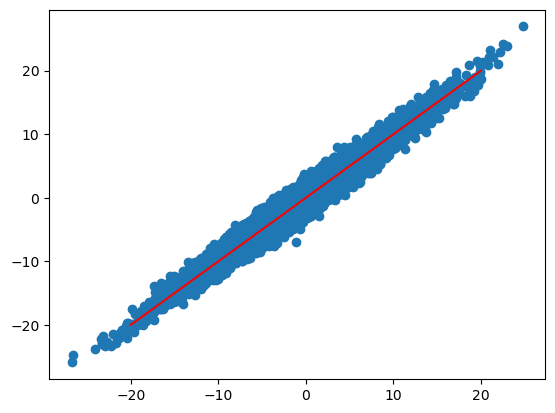

In [14]:
with torch.no_grad():
    zhat, uhat = gl.encoder(dat_true["x"], dat_true["y"])
    yhat = gl.decoder(dat_true["x"], zhat, uhat)

plt.scatter(dat_true["y"], yhat)
plt.plot([-20, 20], [-20, 20], color="red")

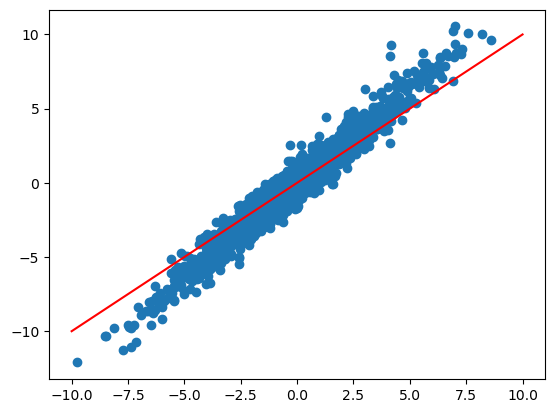

In [16]:
zhat = zhat*-1
plt.scatter(zhat, dat_true["z"])
plt.plot([-10, 10], [-10,10], color="red")

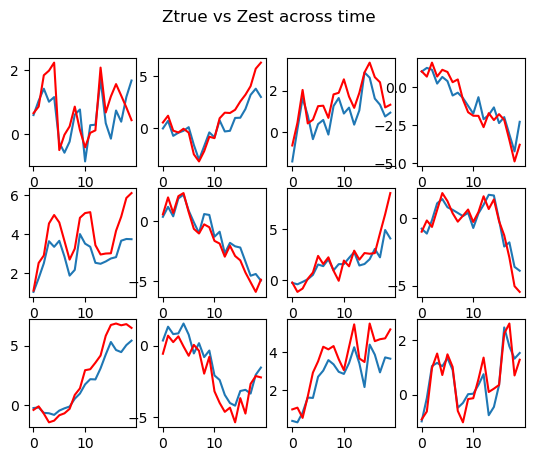

In [17]:
# print 12 randomly selected Z
index = np.random.choice(range(n), 12, replace=False)
fig, axs = plt.subplots(3, 4)

zhat= -zhat
fig.suptitle("Ztrue vs Zest across time")
for i in range(12):
    axs[i//4, i%4].plot(zhat[index[i],:,0]*-1)
    axs[i//4, i%4].plot(dat_true["z"][index[i],:, 0], color="red")

In [ ]:
par_true = gl_true.decoder.parameters().__next__().detach().squeeze()
par_est = gl.decoder.parameters().__next__() .detach().squeeze()

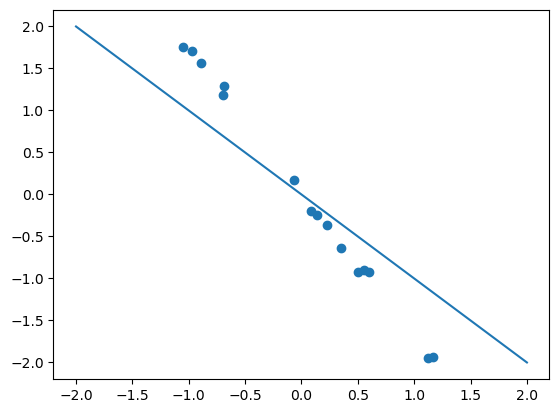

In [ ]:
plt.scatter(par_true, par_est)
plt.plot([-2,2], [2, -2])

Parameter containing:
tensor([[-0.1917,  1.7052,  1.5688, -1.9336,  1.2903, -0.2464, -0.9208, -0.8981,
         -0.3629, -1.9462,  1.1807,  1.7579, -0.6408, -0.9203,  0.1704]],
       requires_grad=True)

In [18]:
rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

In [19]:
input

tensor([[[-0.4933,  1.5256, -1.0954,  0.9415,  0.0749,  0.5721,  0.5594,
          -1.1498,  0.2099,  0.4694],
         [-0.3344,  0.1942, -0.7034,  0.4629, -1.2898,  0.2803, -0.2243,
           1.3108,  2.6134,  0.6426],
         [ 0.1557,  1.5167, -0.6572, -1.2525, -1.5176, -0.1339, -0.8516,
           0.0916,  0.0129,  0.6163]],

        [[ 1.4279,  0.1257,  0.2034,  0.3920,  1.0154, -1.1235, -1.2475,
          -0.4898,  1.0222, -0.8360],
         [-0.6828, -2.2242, -0.4324, -1.1709, -1.9163, -0.1186,  0.6248,
           0.0899,  2.4953,  1.2641],
         [-2.0851, -0.6691, -1.7475, -1.5473, -0.7328,  1.6922, -1.8650,
           0.2673, -1.0303,  0.1084]],

        [[-0.0238,  1.6200, -0.6585,  1.4914, -2.6499, -0.2674,  0.6466,
           0.5169, -1.1068,  0.2170],
         [-1.3180, -0.8179,  0.8362,  0.6499,  0.4542,  1.7222,  1.1707,
          -1.1569,  0.5677,  0.0027],
         [-0.5776, -2.0234, -0.6848,  1.5876,  1.7223, -2.0019, -0.6659,
          -0.7057, -1.1529, -0.5410

### Details on tensor products calculations
We now show the details on the tensor products, for instance for computing `xb @ wx`. `xb` is of size `(n, T, q)` and `wx` is of size `(T, q, p)`. We want a result of size `(n, T, p)`. First we add a dimension for `xb`:

`xb.unsqueeze(2)` which yields a dimensions of `(n, T, 1, q)`

which we then multiply by `wz`:

`(n, T, 1, q) @ (1, q, p)` -> `(n, T, 1, p)`

where the first dimension of `wx` has been broadcasted.

Finally, we squeeze to obtain `(n, T, p)`.